In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LogFormatter 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import yaml

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

In [3]:
df['FiscalYear'] = df['MissionDate'].copy()
df.set_index('MissionDate', drop=False, inplace=True)
df.index.name = 'FiscalYear'

# Grouping records by exact date, fiscal year, MissionID,
# removal or transfer status, unique pickup/dropoff, juvenile status.
# Can't group by nationality here or it splits flights up and obscures trends
g = df.groupby([pd.Grouper(freq='AS-OCT'), 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [4]:
table = g[['AlienMasterID', 'MissionID']].nunique().reset_index()

In [5]:
table.head()

,FiscalYear,MissionDate,R-T,PULOC,DropLoc,AlienMasterID,MissionID
0,2010-10-01,2010-10-01,R,KAEX,MHLM,97,1
1,2010-10-01,2010-10-01,R,KBFL,KSAN,13,1
2,2010-10-01,2010-10-01,R,KCSG,MSLP,33,1
3,2010-10-01,2010-10-01,R,KDEN,KHRL,42,1
4,2010-10-01,2010-10-01,R,KELP,KHRL,46,1


In [6]:
table.set_index('MissionDate', inplace=True)

In [7]:
table.head()

,FiscalYear,R-T,PULOC,DropLoc,AlienMasterID,MissionID
MissionDate,,,,,,
2010-10-01,2010-10-01,R,KAEX,MHLM,97,1
2010-10-01,2010-10-01,R,KBFL,KSAN,13,1
2010-10-01,2010-10-01,R,KCSG,MSLP,33,1
2010-10-01,2010-10-01,R,KDEN,KHRL,42,1
2010-10-01,2010-10-01,R,KELP,KHRL,46,1


In [8]:
table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers', 'flights']
all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')
# table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [9]:
flights = table
# flights = table[all_kbfi]
# flights = pd.read_csv('../output/flight_summary.csv.gz', compression='gzip', sep='|')
# flights = pd.read_csv('../output/guatemala_transfers.csv.gz', compression='gzip', sep='|')

In [10]:
flights.head()

,year,R-T,pickup_airport,dropoff_airport,passengers,flights
MissionDate,,,,,,
2010-10-01,2010-10-01,R,KAEX,MHLM,97,1
2010-10-01,2010-10-01,R,KBFL,KSAN,13,1
2010-10-01,2010-10-01,R,KCSG,MSLP,33,1
2010-10-01,2010-10-01,R,KDEN,KHRL,42,1
2010-10-01,2010-10-01,R,KELP,KHRL,46,1


In [11]:
flights['pickup_airport'] = flights['pickup_airport'].str.upper()
flights['dropoff_airport'] = flights['dropoff_airport'].str.upper()
# flights['pickup_airport'] = flights['PULOC'].str.upper()
# flights['dropoff_airport'] = flights['DropLoc'].str.upper()

In [12]:
flights_loc = set(pd.concat([flights['pickup_airport'], flights['dropoff_airport']]))

In [13]:
bad_airports = ['KKBL']

In [14]:
flights = flights[~flights['pickup_airport'].isin(bad_airports)]
flights = flights[~flights['dropoff_airport'].isin(bad_airports)]

In [15]:
airports = pd.read_csv('../../share/hand/GlobalAirportDatabase.csv.gz', compression='gzip', sep='|')

In [16]:
airports.head()

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDirection,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726


In [17]:
airports_loc = set(airports['ICAOCode'])

In [18]:
airports.set_index('ICAOCode', inplace=True)

In [19]:
airports_missing_loc = ['FLKK', 'FWKI', 'KABQ', 'VTBS']

In [20]:
airports = airports[~airports.index.isin(['FLKK', 'FWKI', 'KABQ', 'VTBS'])]

In [21]:
additional_airports = pd.read_csv('../../share/hand/locations.csv', quotechar='"')

In [22]:
additional_airports.columns = ['ICAOCode', 'CountryISO', 'State', 'City', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']
additional_airports.set_index('ICAOCode', inplace=True)
additional_airports.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [23]:
missing_airports = list(flights_loc.difference(airports_loc))
missing_airports.extend(airports_missing_loc)

In [24]:
airports_2 = additional_airports[additional_airports.index.isin(missing_airports)].copy()

In [25]:
airports_2.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [26]:
airports_2 = airports_2[['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

In [27]:
airports = pd.concat([airports, airports_2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [28]:
arts_airports = list(set(df['PULOC'].append(df['DropLoc'])))

In [29]:
airports_to_merge = airports[airports.index.isin(arts_airports)][['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]



In [30]:
airports_to_merge.to_csv('../output/airports_to_merge.csv')

In [31]:
airports.head()

,AirportName,Altitude,City,Country,IATACode,LatitudeDecimalDegrees,LatitudeDegrees,LatitudeDirection,LatitudeMinutes,LatitudeSeconds,LongitudeDecimalDegrees,LongitudeDegrees,LongitudeDirection,LongitudeMinutes,LongitudeSeconds
ICAOCode,,,,,,,,,,,,,,,
AYGA,GOROKA,1610.0,GOROKA,PAPUA NEW GUINEA,GKA,-6.082,6.0,S,4.0,54.0,145.392,145.0,E,23.0,30.0
AYLA,NaN,0.0,LAE,PAPUA NEW GUINEA,LAE,0.000,0.0,U,0.0,0.0,0.000,0.0,U,0.0,0.0
AYMD,MADANG,7.0,MADANG,PAPUA NEW GUINEA,MAG,-5.207,5.0,S,12.0,25.0,145.789,145.0,E,47.0,19.0
AYMH,MOUNT HAGEN,1643.0,MOUNT HAGEN,PAPUA NEW GUINEA,HGU,-5.826,5.0,S,49.0,34.0,144.296,144.0,E,17.0,46.0
AYNZ,NADZAB,73.0,NADZAB,PAPUA NEW GUINEA,LAE,-6.570,6.0,S,34.0,11.0,146.726,146.0,E,43.0,34.0


In [32]:
edges = flights[['pickup_airport', 'dropoff_airport']].values

In [33]:
g = nx.from_edgelist(edges)

In [34]:
len(g.nodes()), len(g.edges())

(221, 721)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


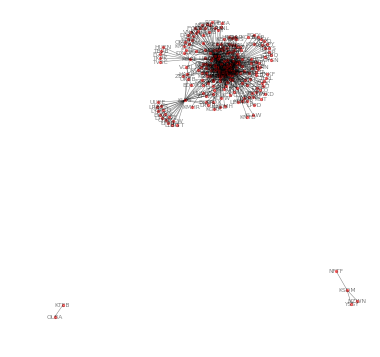

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [36]:
sg = next(nx.connected_component_subgraphs(g))

In [45]:
nx.connected_component_subgraphs(g)

<generator object connected_component_subgraphs at 0xa2ee49b88>

In [52]:
list(nx.connected_component_subgraphs(g))[1].nodes

NodeView(('OLBA', 'KTEB'))

In [53]:
list(nx.connected_component_subgraphs(g))[2].nodes

NodeView(('YSSY', 'NZWN', 'KSDM', 'NFTF'))

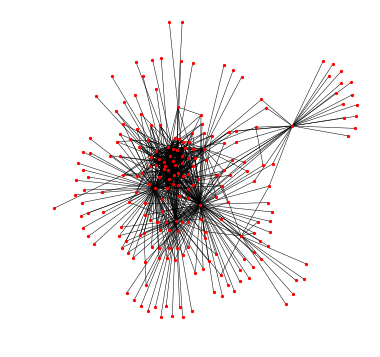

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [207]:
pos = {airport: (v['LongitudeDecimalDegrees'], v['LatitudeDecimalDegrees'])
       for airport, v in
       airports.to_dict('index').items()}

In [208]:
# Dropping unknown locations
pos_unknown = {k:v for k, v in pos.items() if v == (0.0, 0.0)}

In [51]:
pickup_totals = flights.groupby('pickup_airport')['passengers'].sum()
dropoff_totals = flights.groupby('dropoff_airport')['passengers'].sum()

In [67]:
passenger_totals = pd.concat([pickup_totals, dropoff_totals])

In [141]:
passenger_total = pd.Series(passenger_totals[icao].sum() for icao in sg.nodes)

In [175]:
deg = nx.degree(sg)
sizes = [5 * deg[icao] for icao in sg.nodes]

In [178]:
labels = {icao: icao if passenger_totals[icao].sum() >= 30000 else ''
          for icao in sg.nodes}
no_labels = {icao: '' for icao in sg.nodes}

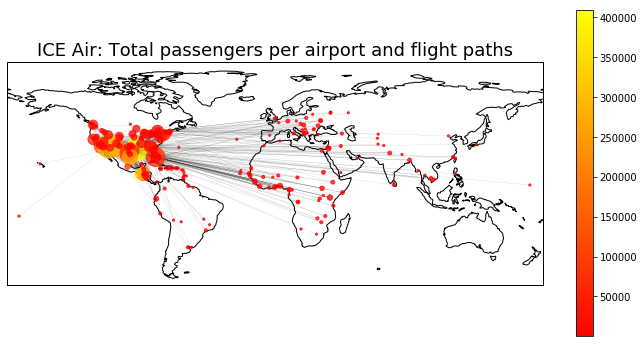

In [211]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()

# Extent of continental US.
# ax.set_extent([-128, -62, 10, 50])
# Global
ax.set_extent([-180, 180, -60, 90])

cmap = plt.cm.autumn

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.75,
                 width=.075,
                 node_size=sizes,
                 node_color=passenger_total,
                 labels=no_labels,
                 pos=pos,
                 cmap=cmap)

vmin = passenger_total.min()
vmax = passenger_total.max()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, shrink=.75)
plt.title("ICE Air: Total passengers per airport and flight paths", size=18)
plt.show()

# Choropleth

/Users/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


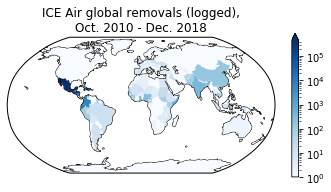

In [237]:
cmap = mpl.cm.Blues
# Countries is a dictionary of {"country_name": number of users}, for example
countries = df[df['R-T'] == 'R'].groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique().to_dict()

min_passengers = float(min(countries.values()))
max_passengers = float(max(countries.values()))
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()

for country in shpreader.Reader(countries_shp).records():
    name = country.attributes['NAME_LONG'].upper()
    try:
        num_passengers = countries[name]
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=cmap(np.log(num_passengers)/np.log(max_passengers)))
    except:
        num_passengers = 0
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=cmap(num_passengers))
        pass

# formatter = LogFormatter(labelOnlyBase=False) 
    
sm = plt.cm.ScalarMappable(cmap=cmap,norm=colors.LogNorm(vmin=1, vmax=max_passengers))
sm._A = []
plt.colorbar(sm, ax=ax, shrink=.66, extend='max')

plt.title('ICE Air global removals (logged),\nOct. 2010 - Dec. 2018')

plt.savefig('../output/removal_choropleth.png', transparent=True, dpi=900)